<a href="https://colab.research.google.com/github/mflazaro/bases_ds_python/blob/main/ProyectoDS_ParteII_Lazaro_draft.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Objetivo: ¿Cómo podemos predecir si un prestario va a defaultear su deuda?**

In [22]:
import pandas as pd
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
from matplotlib import dates as mpl_dates
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

from scipy.stats import zscore
from scipy.stats.mstats import winsorize

import json
import requests
from bs4 import BeautifulSoup



# **Introduccion**

**Contexto empresarial.** El otorgamiento de distintos tipos de préstamos a clientes conforma una de los principales productos y negocios de las entidades bancarias. Dado lo anterior, el riesgo de crédito es uno de los principales riesgos a gestionar por estas entidades. Así la detección de clientes que pueden entrar en default se convierte en una tarea fundamental y necesaria para perimitir el desarrollo y sostenibilidad del negocio.

En este contexto, una importante entidad bancaria nos ha contratado para que construir visualizaciones que permitan identificar patrones de clientes con alta probabilidad de incurrir en default. Esto último permitiría realizar una mejor detección de futuros posibles clientes morosos y otorgar créditos a los los clientes que presenten menor riesgo. Para ello, contamos con datos como:

person_age:	Age

person_income:	Annual Income

person_home_ownership:	Home ownership

person_emp_length:	Employment length (in years)

loan_intent:	Loan intent

loan_grade;	Loan grade

loan_amnt;	Loan amount

loan_int_rate:	Interest rate

loan_status:	Loan status (0 is non default 1 is default)

loan_percent_income:	Percent income

cb_person_default_on_file:	Historical default

cb_preson_cred_hist_length:	Credit history length

**Problema comercial.** Nuestra tarea es formatear los datos proporcionados y proporcionar visualizaciones que respondan las preguntas específicas que tiene el cliente, que se mencionan a continuación.

**Contexto analítico.** La entidad bancaria ha proporciona un archivo CSV que contiene detalles sobre clientes mencionados anteriormente. El delimitador en el archivo CSV dado es ",". realizaremos las siguientes tareas con los datos:

1.   Extraer los datos proporcionados,

2.   Leer, transformar y preparar los datos para su visualización,

3.   Realizaremos análisis y contruiremos visualizaciones de los datos para identificar patrones en el conjunto de datos.

El cliente tiene un conjunto específico de preguntas a las que nos gustaría obtener respuestas. Partimos de la base de que el cliente supone que los clientes con mayores recursos son los llamados "mejores" clientes, ya que tendrían menor probabilidad de default. A partir de lo anterior, el cliente plantea las siguientes preguntas:

¿Las personas con menores ingresos tienen mayor probabilidad de incumplir sus préstamos?

¿La antiguedad laboral podría ser un indicador que de garantía de que una persona va a cumplir su préstamo?

¿Las personas con mayor antiguedad laboral suelen tener mejores salarios?

Las personas que poseen una propiedad, ¿tienen un mejor mejor grado crediticio o loan grade? ¿y las personas con mejores salarios?¿y las personas con mayor antiguedad laboral?



In [3]:
url_ds_2 = 'https://raw.githubusercontent.com/mflazaro/bases_ds_python/main/credit_risk_dataset.csv'

df = pd.read_csv(url_ds_2)

df.head(5)

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


In [ ]:
df.columns

Index(['person_age', 'person_income', 'person_home_ownership',
       'person_emp_length', 'loan_intent', 'loan_grade', 'loan_amnt',
       'loan_int_rate', 'loan_status', 'loan_percent_income',
       'cb_person_default_on_file', 'cb_person_cred_hist_length'],
      dtype='object')

Como se mencionó al inicio, tenemos las siguientes columnas

**person_age:**	Age

**person_income:**	Annual Income

**person_home_ownership:**	Home ownership

**person_emp_length:**	Employment length (in years)

**loan_intent:**	Loan intent

**loan_grade:** Loan grade. From A to G, being G the riskiest grade.

**loan_amnt:**	Loan amount

**loan_int_rate:**	Interest rate

**loan_status:**	Loan status (0 is non default 1 is default)

**loan_percent_income:**	Percent income

**cb_person_default_on_file:**	Historical default

**cb_preson_cred_hist_length:**	Credit history length

In [ ]:
df.describe()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length
count,32581.000000,3.258100e+04,31686.000000,32581.000000,29465.000000,32581.000000,32581.000000,32581.000000
mean,27.734600,6.607485e+04,4.789686,9589.371106,11.011695,0.218164,0.170203,5.804211
std,6.348078,6.198312e+04,4.142630,6322.086646,3.240459,0.413006,0.106782,4.055001
min,20.000000,4.000000e+03,0.000000,500.000000,5.420000,0.000000,0.000000,2.000000
25%,23.000000,3.850000e+04,2.000000,5000.000000,7.900000,0.000000,0.090000,3.000000
50%,26.000000,5.500000e+04,4.000000,8000.000000,10.990000,0.000000,0.150000,4.000000
75%,30.000000,7.920000e+04,7.000000,12200.000000,13.470000,0.000000,0.230000,8.000000
max,144.000000,6.000000e+06,123.000000,35000.000000,23.220000,1.000000,0.830000,30.000000


In [ ]:
df.loan_status.unique()

array([1, 0])

In [ ]:
df.corr()

<ipython-input-7-2f6f6606aa2c>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.corr()


,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length
person_age,1.000000,0.173202,0.163106,0.050787,0.012580,-0.021629,-0.042411,0.859133
person_income,0.173202,1.000000,0.134268,0.266820,0.000792,-0.144449,-0.254471,0.117987
person_emp_length,0.163106,0.134268,1.000000,0.113082,-0.056405,-0.082489,-0.054111,0.144699
loan_amnt,0.050787,0.266820,0.113082,1.000000,0.146813,0.105376,0.572612,0.041967
loan_int_rate,0.012580,0.000792,-0.056405,0.146813,1.000000,0.335133,0.120314,0.016696
loan_status,-0.021629,-0.144449,-0.082489,0.105376,0.335133,1.000000,0.379366,-0.015529
loan_percent_income,-0.042411,-0.254471,-0.054111,0.572612,0.120314,0.379366,1.000000,-0.031690
cb_person_cred_hist_length,0.859133,0.117987,0.144699,0.041967,0.016696,-0.015529,-0.031690,1.000000


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32581 non-null  int64  
 1   person_income               32581 non-null  int64  
 2   person_home_ownership       32581 non-null  object 
 3   person_emp_length           31686 non-null  float64
 4   loan_intent                 32581 non-null  object 
 5   loan_grade                  32581 non-null  object 
 6   loan_amnt                   32581 non-null  int64  
 7   loan_int_rate               29465 non-null  float64
 8   loan_status                 32581 non-null  int64  
 9   loan_percent_income         32581 non-null  float64
 10  cb_person_default_on_file   32581 non-null  object 
 11  cb_person_cred_hist_length  32581 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.0+ MB


# **Respondiendo las preguntas del cliente**

¿Las personas con menores ingresos tienen mayor probabilidad de incumplir sus préstamos?

Text(0.5, 0, 'Person Income')

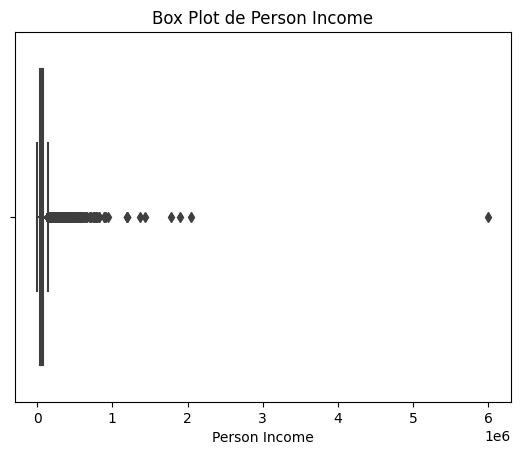

In [24]:
#Primero analizamos los datos de la variable person_income
g = sns.boxplot(data = df, x = 'person_income')
g.set_title('Box Plot de Person Income')
g.set_xlabel('Person Income')


In [25]:
#Tratamiento de outliers
z_scores = zscore(df['person_income'])
abs_z_scores = np.abs(z_scores)
outliers = df[abs_z_scores > 3]
outliers.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
15,23,500000,MORTGAGE,7.0,DEBTCONSOLIDATION,B,30000,10.65,0,0.06,N,3
33,25,306000,RENT,2.0,DEBTCONSOLIDATION,C,24250,13.85,0,0.08,N,3
34,26,300000,MORTGAGE,10.0,MEDICAL,C,7800,13.49,0,0.03,N,4
42,26,300000,MORTGAGE,10.0,VENTURE,A,20000,7.88,0,0.07,N,4
43,23,300000,OWN,1.0,EDUCATION,F,24250,19.41,0,0.08,Y,2


In [26]:
#Winzorizar los outliers
df_winsorized = df.copy()
df_winsorized['person_income'] = winsorize(df_winsorized['person_income'],\
  limits = [0.05, 0.05], inplace = True)

Text(0.5, 0, 'Person Income')

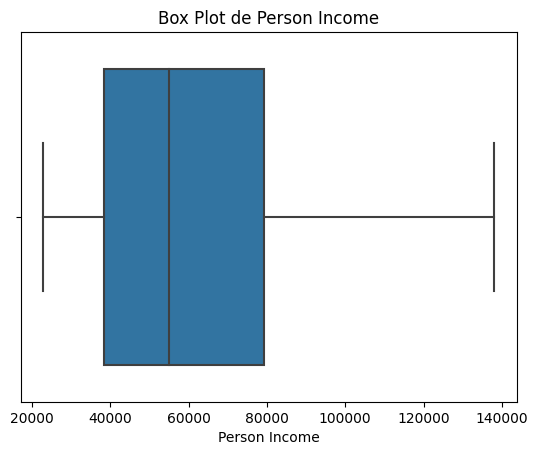

In [27]:
g = sns.boxplot(data = df_winsorized, x = 'person_income')
g.set_title('Box Plot de Person Income')
g.set_xlabel('Person Income')

In [45]:
df_winsorized.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32581 non-null  int64  
 1   person_income               32581 non-null  int64  
 2   person_home_ownership       32581 non-null  object 
 3   person_emp_length           31686 non-null  float64
 4   loan_intent                 32581 non-null  object 
 5   loan_grade                  32581 non-null  object 
 6   loan_amnt                   32581 non-null  int64  
 7   loan_int_rate               29465 non-null  float64
 8   loan_status                 32581 non-null  int64  
 9   loan_percent_income         32581 non-null  float64
 10  cb_person_default_on_file   32581 non-null  object 
 11  cb_person_cred_hist_length  32581 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.0+ MB


In [28]:
#se crea DF solo con los clientes que hayan defaulteado prestamos en la actualidad (no se considera para el análisis la variable cb_person_default_on_file)
df_default_w = df_winsorized[(df.loan_status > 0)]
df_default_w.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
2,25,22880,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4
5,21,22880,OWN,2.0,VENTURE,A,2500,7.14,1,0.25,N,2


In [31]:
df_default_w.describe()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length
count,7108.000000,7108.000000,6826.000000,7108.000000,6464.000000,7108.0,7108.000000,7108.000000
mean,27.474676,48518.948931,4.137562,10850.502954,13.060207,1.0,0.246889,5.685003
std,6.263642,26135.573603,4.126956,7143.345344,3.293167,0.0,0.132148,4.103208
min,20.000000,22880.000000,0.000000,900.000000,5.420000,1.0,0.010000,2.000000
25%,23.000000,30000.000000,1.000000,5000.000000,10.740000,1.0,0.140000,3.000000
50%,26.000000,41498.000000,3.000000,9600.000000,13.490000,1.0,0.240000,4.000000
75%,30.000000,59497.750000,6.000000,15000.000000,15.580000,1.0,0.340000,8.000000
max,70.000000,138000.000000,123.000000,35000.000000,23.220000,1.0,0.780000,30.000000


Text(0, 0.5, 'Total de clientes')

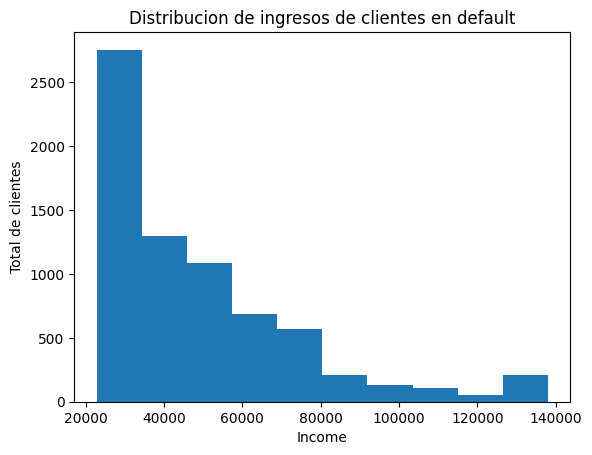

In [29]:
plt.hist(df_default_w.person_income)
plt.title('Distribucion de ingresos de clientes en default')
plt.xlabel('Income')
plt.ylabel('Total de clientes')

En base a la pregunta planteada, se observa claramente que de los clientes que han presentado default en los préstamos analizados, a medida que aumentan los ingresos desciende la cantidad de préstamos defaulteados. Por ende, ante este primer acercamiento de la información, se podría esperar a un menor ingreso mayor probabilidad de default.  

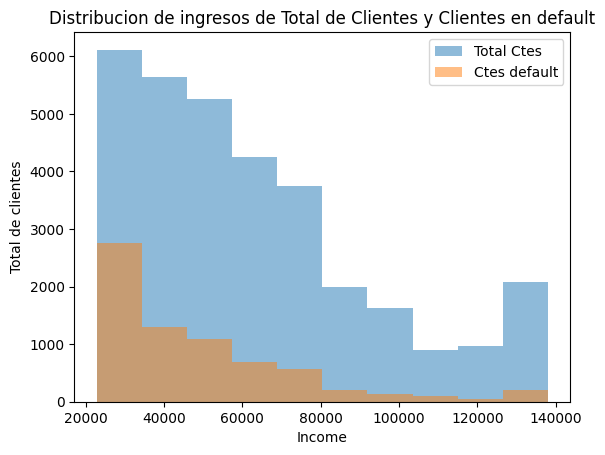

In [54]:
plt.hist(df_winsorized.person_income,alpha=0.5, label='Total Ctes')
plt.hist(df_default_w.person_income, alpha=0.5, label='Ctes default')
plt.legend(loc='upper right')
plt.title('Distribucion de ingresos de Total de Clientes y Clientes en default')
plt.xlabel('Income')
plt.ylabel('Total de clientes')
plt.show()

Con esta segunda gráfica, podemos observar que la distribución de los ingresos del total de clientes es muy similar a la distribución de los clientes que defaultearon los prestamos. Esto último podría ser un indicador de que los ingresos podrían no ser indicadores de un posible futuro default, pero cabe destacar que la primer barra correspondiente a los menores ingresos de ambas series de datos (total y con default) se pronunciadamente alta para la serie con default y se pierde la relación descripta anteriormente. Esto último, arroja un indicio de que los ingresos tendrían cierta relación con la posibilidad de default principalmente para aquellas personas con menores ingresos.

¿La antiguedad laboral podría ser un indicador que de garantía de que una persona va a cumplir su préstamo?

Text(0, 0.5, 'Total de clientes')

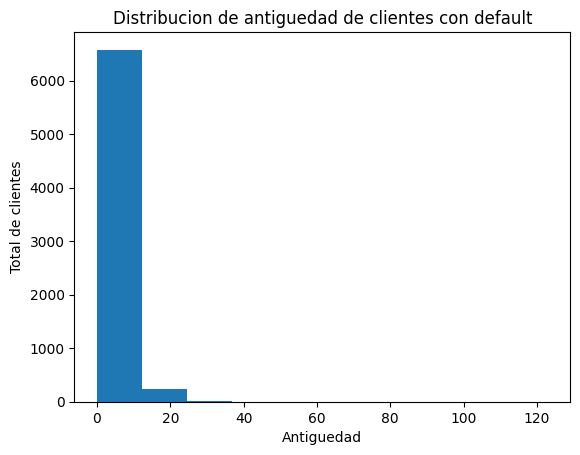

In [57]:
plt.hist(df_default_w.person_emp_length)
plt.title('Distribucion de antiguedad de clientes con default')
plt.xlabel('Antiguedad')
plt.ylabel('Total de clientes')

Text(0.5, 0, 'Antiguedad')

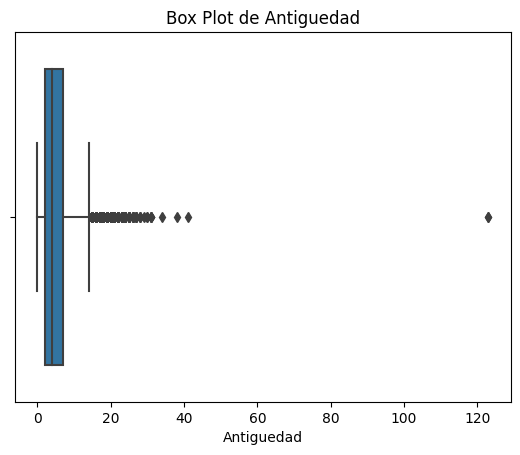

In [58]:
g = sns.boxplot(data = df_winsorized, x = 'person_emp_length')
g.set_title('Box Plot de Antiguedad')
g.set_xlabel('Antiguedad')

In [ ]:

taxis_imputed = taxis.copy()
taxis_imputed.loc[outliers.index, 'total'] = median_value